In [18]:
import pandas as pd

# 파일 경로
file_path = './data/한국동서발전(주)_제주 기상관측 및 태양광 발전 현황_20221231_거의_원본.csv'

# 데이터 불러오기
df = pd.read_csv(file_path)

# 결측값 확인
print(df.isnull().sum())

# T열의 결측값이 있는 행 제거
df = df.dropna(subset=['T'])



# 기온(T)과 일사량(GHI)에서 비정상적인 값 확인
df = df[(df['T'] > -30) & (df['T'] < 50)]  # 기온이 -30도에서 50도 사이에 있어야 함
df = df[df['GHI'] >= 0]  # 일사량은 음수가 될 수 없음




YEAR                   0
MONTH                  0
DAY                    0
HOUR                   0
T                      5
PR                     0
H                      0
SF                     0
CC                     0
SD                     0
GHI                    0
PV_capacity            0
GEN                    0
GEN_PER_PV_capacity    0
dtype: int64


<h2 style="color:red;"> 기온 5개 결측값</h2>

In [19]:
print(df.isnull().sum())

YEAR                   0
MONTH                  0
DAY                    0
HOUR                   0
T                      0
PR                     0
H                      0
SF                     0
CC                     0
SD                     0
GHI                    0
PV_capacity            0
GEN                    0
GEN_PER_PV_capacity    0
dtype: int64


In [20]:
df[(df['T'] <= -20) | (df['T'] >= 40)]   # 기온이 -30도에서 50도 사이에 있으므로 이상치 없음!

,YEAR,MONTH,DAY,HOUR,T,PR,H,SF,CC,SD,GHI,PV_capacity,GEN,GEN_PER_PV_capacity


In [21]:
df[df['GHI'] < 0]   # 일사량이 음수인 경우도 없음! -> 이상치 없음

,YEAR,MONTH,DAY,HOUR,T,PR,H,SF,CC,SD,GHI,PV_capacity,GEN,GEN_PER_PV_capacity


In [22]:
from sklearn.preprocessing import MinMaxScaler

# 정규화할 열 선택
columns_to_scale = ['T', 'PR', 'H', 'SF', 'CC', 'SD', 'GHI']

# MinMaxScaler 사용하여 0~1로 정규화
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])



In [23]:
# 이전 시간대의 기온(T-1)과 일사량(GHI-1) 생성
df['T-1'] = df['T'].shift(1)
df['GHI-1'] = df['GHI'].shift(1)

# NaN 값이 생기므로, 첫 행 삭제
df.dropna(inplace=True)


In [24]:
# 상관관계 행렬 계산
correlation_matrix = df.corr()

# TARGET과 상관관계가 높은 변수 확인
print(correlation_matrix['GEN_PER_PV_capacity'].sort_values(ascending=False))


GEN_PER_PV_capacity    1.000000
GEN                    0.995790
GHI                    0.881168
SD                     0.757780
GHI-1                  0.738744
T                      0.177294
T-1                    0.140290
HOUR                   0.069174
YEAR                   0.011753
DAY                    0.005374
PV_capacity           -0.023595
SF                    -0.036374
MONTH                 -0.050257
PR                    -0.059061
CC                    -0.269043
H                     -0.349481
Name: GEN_PER_PV_capacity, dtype: float64


In [20]:
# 전처리된 데이터 저장
df.to_csv('./data/전처리된_제주_태양광_발전_데이터.csv', index=False)


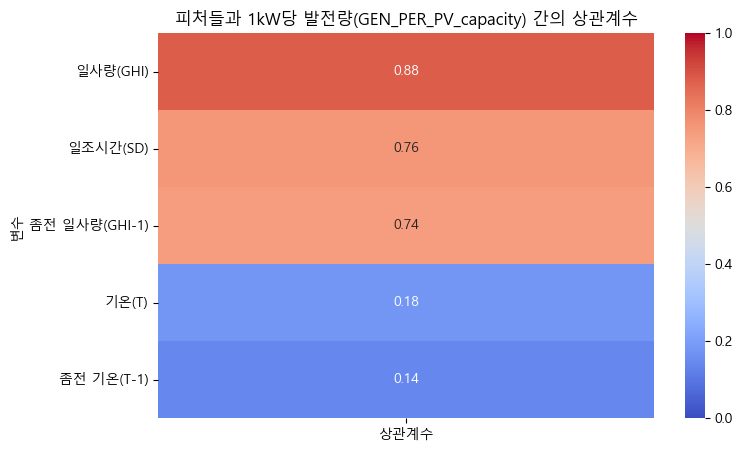

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


# 상관계수 데이터 재구성
corr_data = {
    '변수': ['일사량(GHI)', '일조시간(SD)', '좀전 일사량(GHI-1)', '기온(T)', '좀전 기온(T-1)'],
    '상관계수': [0.881168, 0.757780, 0.738744, 0.177294, 0.140290]
}

# 데이터프레임 생성
df_corr = pd.DataFrame(corr_data)
df_corr.set_index('변수', inplace=True)


# 한글 깨짐 방지
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 그래프 그리기
plt.figure(figsize=(8, 5))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar=True)

plt.title('피처들과 1kW당 발전량(GEN_PER_PV_capacity) 간의 상관계수')
plt.show()


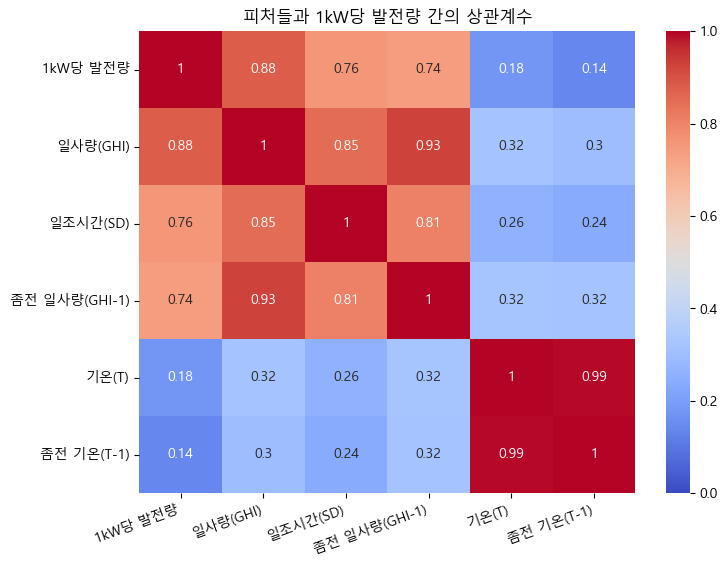

In [26]:
corr_matrix = df[['GEN_PER_PV_capacity', 'GHI', 'SD', 'GHI-1', 'T', 'T-1']].corr()

# 한글 변수명을 매핑
corr_matrix.index = ['1kW당 발전량', '일사량(GHI)', '일조시간(SD)', '좀전 일사량(GHI-1)', '기온(T)', '좀전 기온(T-1)']
corr_matrix.columns = corr_matrix.index

# 그래프 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar=True)
# x축 레이블 45도 회전
plt.xticks(rotation=20, ha='right')


plt.title('피처들과 1kW당 발전량 간의 상관계수')
plt.show()

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

data= df

# 독립 변수와 종속 변수 분리
X = data[['T', 'PR', 'H', 'SF', 'CC', 'SD', 'GHI','T-1','GHI-1']]
y = data['GEN_PER_PV_capacity']

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost 모델 설정
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 하이퍼파라미터 튜닝 (옵션)
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# 최적의 모델 선택
best_xg_reg = grid_search.best_estimator_

# 테스트 세트에 대해 예측 수행
y_pred = best_xg_reg.predict(X_test_scaled)

# 성능 평가
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# 성능 평가2 (정확도 계산)
non_zero_indices = y_test != 0
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
# SMAPE 계산
smape_value = smape(y_test[non_zero_indices], y_pred[non_zero_indices])

print(f'결정 계수 (R²): {r2}')
print(f'평균제곱오차 (MSE): {mse}')
print(f'평균제곱오차의 제곱근 (RMSE): {rmse}')
print(f'평균절대오차 (MAE): {mae}')
print(f'평균 절대 백분율 오류(SMAPE): {smape_value}%')
print('''
-정확도
   -결정 계수는 1에 가까울 수록
   -평균제곱오차는 작을수록
   -평균절대오차도 작을수록
   -평균 절대 백분율 오류도 0에 가까울 수록
    정확합니다''')


결정 계수 (R²): 0.9185111913008392
평균제곱오차 (MSE): 3612.46412870156
평균제곱오차의 제곱근 (RMSE): 60.103777990252496
평균절대오차 (MAE): 32.96981384740762
평균 절대 백분율 오류(SMAPE): 71.81438963712317%

-정확도
   -결정 계수는 1에 가까울 수록
   -평균제곱오차는 작을수록
   -평균절대오차도 작을수록
   -평균 절대 백분율 오류도 0에 가까울 수록
    정확합니다


<h2 style="color:cyan;"> 결정계수가 0.918이고 나머지 지표도 좋다. 성능이 좋다!</h2>

In [40]:
import joblib

# 최적의 XGBoost 모델 저장
joblib.dump(best_xg_reg, './data/대구 발전량 예측 관련 데이터/best_xgboost_model_with_SD.pkl')

# 데이터 스케일러 저장
joblib.dump(scaler, './data/대구 발전량 예측 관련 데이터/scaler_with_SD.pkl')


['./data/대구 발전량 예측 관련 데이터/scaler_with_SD.pkl']

In [41]:
# 모델과 스케일러 불러오기
loaded_model = joblib.load('./data/대구 발전량 예측 관련 데이터/best_xgboost_model_with_SD.pkl')
loaded_scaler = joblib.load('./data/대구 발전량 예측 관련 데이터/scaler_with_SD.pkl')

# 예제 데이터에 대한 예측 수행 (X_test_scaled로 변환하여 사용)
X_new_scaled = loaded_scaler.transform(X_test)  # 새로운 데이터 스케일링
y_new_pred = loaded_model.predict(X_new_scaled)

print(y_new_pred)

[  6.9656487   6.110936    6.5444226 ... 506.82047     5.681511
  97.038864 ]


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

data= df

# 독립 변수와 종속 변수 분리
X = data[['T', 'PR', 'H', 'SF', 'CC', 'GHI','T-1','GHI-1']]
y = data['GEN_PER_PV_capacity']

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost 모델 설정
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 하이퍼파라미터 튜닝 (옵션)
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# 최적의 모델 선택
best_xg_reg = grid_search.best_estimator_

# 테스트 세트에 대해 예측 수행
y_pred = best_xg_reg.predict(X_test_scaled)

# 성능 평가
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# 성능 평가2 (정확도 계산)
non_zero_indices = y_test != 0
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
# SMAPE 계산
smape_value = smape(y_test[non_zero_indices], y_pred[non_zero_indices])

print(f'결정 계수 (R²): {r2}')
print(f'평균제곱오차 (MSE): {mse}')
print(f'평균제곱오차의 제곱근 (RMSE): {rmse}')
print(f'평균절대오차 (MAE): {mae}')
print(f'평균 절대 백분율 오류(SMAPE): {smape_value}%')
print('''
-정확도
   -결정 계수는 1에 가까울 수록
   -평균제곱오차는 작을수록
   -평균절대오차도 작을수록
   -평균 절대 백분율 오류도 0에 가까울 수록
    정확합니다''')


결정 계수 (R²): 0.9111306823167746
평균제곱오차 (MSE): 3939.648000721614
평균제곱오차의 제곱근 (RMSE): 62.76661533587433
평균절대오차 (MAE): 34.2101387643027
평균 절대 백분율 오류(SMAPE): 72.52426112320394%

-정확도
   -결정 계수는 1에 가까울 수록
   -평균제곱오차는 작을수록
   -평균절대오차도 작을수록
   -평균 절대 백분율 오류도 0에 가까울 수록
    정확합니다


<h2 style="color:cyan;"> 대구 데이터에서는 일조시간 데이터가 부정확하므로 일조시간 없는 모델도 만듦 </h2>
<h2 style="color:cyan;"> 일조시간 데이터가 없어서 성능이 조금(0.7%) 떨어졌지만 양호함</h2>

In [32]:
import joblib

# 최적의 XGBoost 모델 저장
joblib.dump(best_xg_reg, './data/대구 발전량 예측 관련 데이터/best_xgboost_model_without_SD.pkl')

# 데이터 스케일러 저장
joblib.dump(scaler, './data/대구 발전량 예측 관련 데이터/scaler_without_SD.pkl')

['./data/대구 발전량 예측 관련 데이터/scaler_test.pkl']

In [33]:
# 모델과 스케일러 불러오기
loaded_model = joblib.load('./data/대구 발전량 예측 관련 데이터/best_xgboost_model_without_SD.pkl')
loaded_scaler = joblib.load('./data/대구 발전량 예측 관련 데이터/scaler_without_SD.pkl')

# 예제 데이터에 대한 예측 수행 (X_test_scaled로 변환하여 사용)
X_new_scaled = loaded_scaler.transform(X_test)  # 새로운 데이터 스케일링
y_new_pred = loaded_model.predict(X_new_scaled)

print(y_new_pred)

[  7.213941    6.1286955   6.8788767 ... 450.36304     5.7052073
  97.64854  ]


C:\Users\tlgud\AppData\Local\Temp\ipykernel_3048\3950451062.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_20200101.dropna(inplace=True)


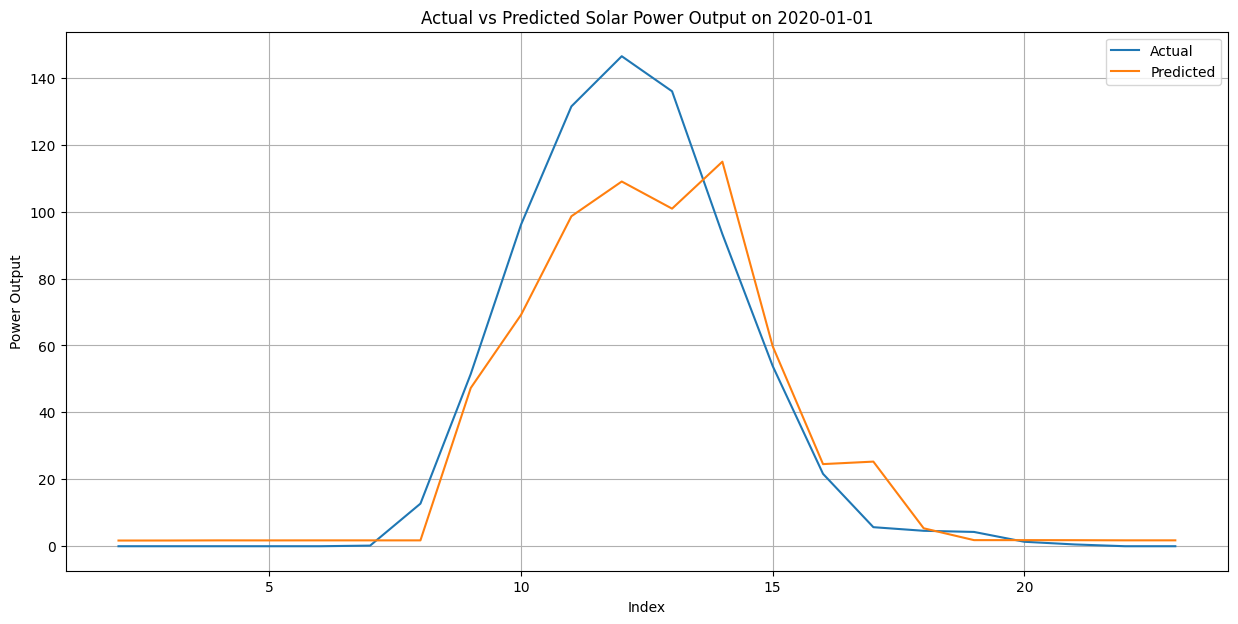

In [27]:
import matplotlib.pyplot as plt


# 2020년 1월 1일 데이터 필터링
data_20200101 = data[(data['Year'] == 2020) & (data['Month'] == 1) & (data['Day'] == 1)]
# 결측치 제거
data_20200101.dropna(inplace=True)


# 스케일링 및 예측 수행
X_20200101 = data_20200101[['T', 'PR', 'H', 'SF', 'CC', 'SD', 'GHI', 'T-1', 'GHI-1']]
X_20200101_scaled = scaler.transform(X_20200101)

# 예측 수행
y_20200101_pred = best_xg_reg.predict(X_20200101_scaled)

# 그래프 그리기
plt.figure(figsize=(15, 7))
plt.plot(data_20200101.index, data_20200101['TARGET'], label='Actual')  # 실제값 그리기
plt.plot(data_20200101.index, y_20200101_pred, label='Predicted')  # 예측값 그리기
plt.title('Actual vs Predicted Solar Power Output on 2020-01-01')
plt.xlabel('Index')
plt.ylabel('Power Output')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\tlgud\AppData\Local\Temp\ipykernel_3048\2297659805.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_20200102.dropna(inplace=True)


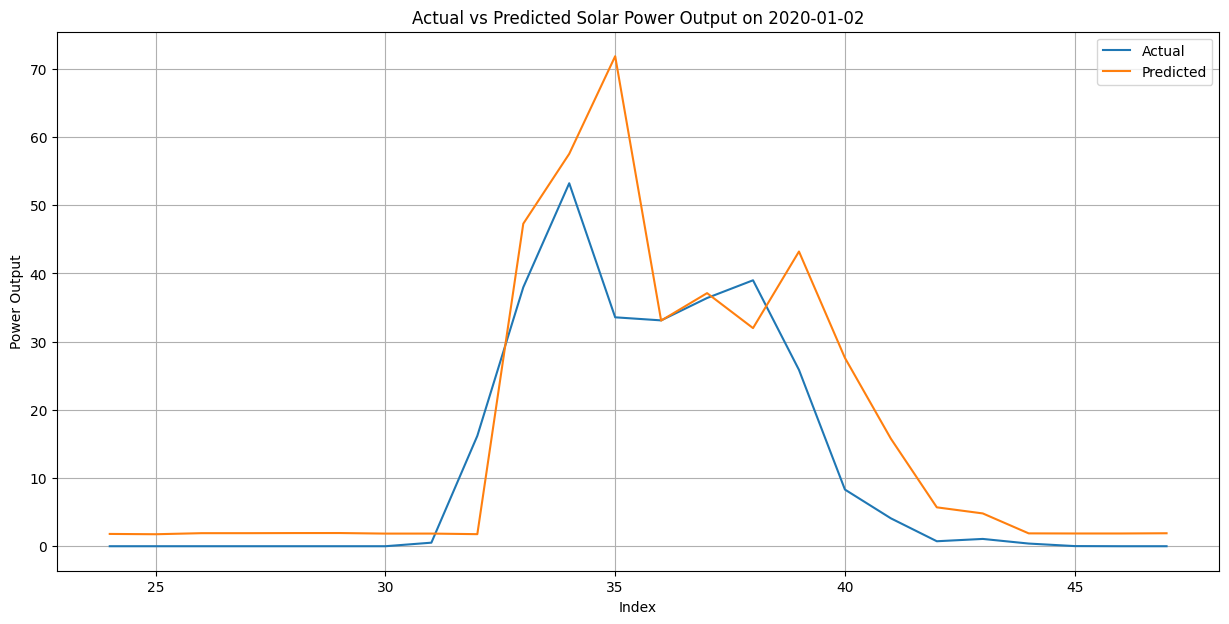

In [29]:
# 2020년 1월 2일 데이터 필터링
data_20200102 = data[(data['Year'] == 2020) & (data['Month'] == 1) & (data['Day'] == 2)]
# 결측치 제거
data_20200102.dropna(inplace=True)


# 스케일링 및 예측 수행
X_20200102 = data_20200102[['T', 'PR', 'H', 'SF', 'CC', 'SD', 'GHI', 'T-1', 'GHI-1']]
X_20200102_scaled = scaler.transform(X_20200102)

# 예측 수행
y_20200102_pred = best_xg_reg.predict(X_20200102_scaled)

# 그래프 그리기
plt.figure(figsize=(15, 7))
plt.plot(data_20200102.index, data_20200102['TARGET'], label='Actual')  # 실제값 그리기
plt.plot(data_20200102.index, y_20200102_pred, label='Predicted')  # 예측값 그리기
plt.title('Actual vs Predicted Solar Power Output on 2020-01-02')
plt.xlabel('Index')
plt.ylabel('Power Output')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


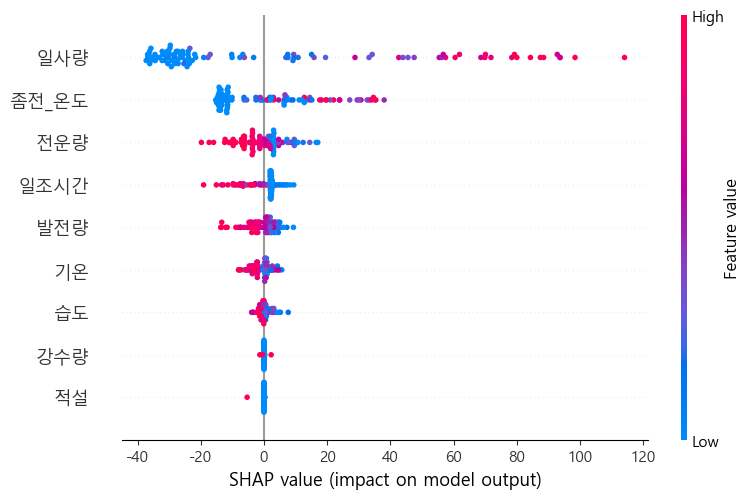

In [34]:
import shap


# SHAP 분석을 위한 배경 데이터 샘플링 (예: 100개의 샘플 사용)
background_sample = shap.sample(X_train_scaled, 100)

# SHAP 분석을 위한 Explainer 생성
explainer = shap.KernelExplainer(best_xg_reg.predict, background_sample)

# 테스트 세트에 대해 SHAP 값을 계산 (최대 100개의 샘플 사용)
shap_values = explainer.shap_values(X_test_scaled[:100])


# 한글 깨짐 방지
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# SHAP 값 시각화 (각 변수의 기여도를 설명)
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=["기온", "강수량", "습도", "적설", "전운량", "일조시간", "일사량", "발전량","좀전_온도","좀전_일사량"])

<h3 style="font-weight:800; background-color:#FFE6E6; color:red;">
    일사량: 이 피처는 전체적으로 SHAP 값이 양수, 모델 예측에 큰 영향을 주고 있어. 즉, 일사량이 많을수록 발전량이 높아짐
</h3>

<h3 style="font-weight:800; background-color:#FFE6E6; color:red;">
    좀전_온도: 이 피처는 주로 음수 방향으로 영향을 미치는 것으로 보이지만, 일부는 양수 방향으로도 영향을 미침. 즉, 좀전_온도 값이 낮을 때 발전량을 낮추고, 높은 경우 일부 발전량을 높일 수 있음
</h3>

<h3 style="font-weight:800; background-color:#FFE6E6; color:red;">
    전운량, 일조시간: 이 피처들도 예측에 영향을 미치지만, 영향이 적음
</h3>

In [ ]:
# SHAP 값 계산 (이미 구했다고 가정)
# shap_values는 모델에 대해 이미 구해진 SHAP 값 배열이라고 가정합니다.
shap_values = explainer.shap_values(X_test_scaled[:100])

# SHAP 값의 절대값을 취한 뒤 평균 계산
feature_importance = np.mean(np.abs(shap_values), axis=0)

# feature importance를 pandas DataFrame으로 변환
feature_names = ['산란일사량', '직달일사량', '상대습도', '풍량', '기온']
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# 중요도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('중요도')
plt.title('특성 중요도 (SHAP)')
plt.gca().invert_yaxis()  # 중요도가 높은 특성이 위로 오도록 반전
plt.show()
